In [3]:
from multiprocessing.pool import Pool
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import inferencer_functions as inferencer

cores_to_use = os.cpu_count() - 2

nfft: 32


In [4]:
model_path = 'data/gbc_model_87_features_2023-09-06_145115.pickle'

## Parameters for the user to set

In [5]:
filepath = 'data/data_with_cs_tng00023_1679404072.301529.csv' # path to your file with ghi data
# please note that the model was evaluated for solar zenith angles <= 85°. 
# Model performance for higher zenith angles may deteriorate.

ghi_column = 'Gg_pyr' # name of column with GHI
ghi_cs_column = 'ghi_cs_haurwitz' # name of column with clear-sky GHI
datetime_column = 'datetime' # name of column with datetime in a standard format (e.g., y-m-d H:M:S)
station_column = 'LocationID' # a column with an identifier for each station

ground_truth_column = None # if available, the name of a column with ground truth, i.e., clear-sky labels

### Read data

In [6]:
df = pd.read_csv(filepath)
df = df[[datetime_column, ghi_column, ghi_cs_column, station_column]]
df[datetime_column] = pd.to_datetime(df[datetime_column])
df['date'] = df[datetime_column].apply(lambda x: x.date)
df

datetime  Gg_pyr  ghi_cs_haurwitz LocationID  \
0      2021-10-01 06:03:00+00:00    50.3        50.126358   tng00023   
1      2021-10-01 06:04:00+00:00    47.1        52.776847   tng00023   
2      2021-10-01 06:05:00+00:00    42.4        55.448596   tng00023   
3      2021-10-01 06:06:00+00:00    46.0        58.139960   tng00023   
4      2021-10-01 06:07:00+00:00    55.1        60.849434   tng00023   
...                          ...     ...              ...        ...   
184944 2022-09-29 16:35:00+00:00    24.7        60.374540   tng00023   
184945 2022-09-29 16:36:00+00:00    24.0        57.652331   tng00023   
184946 2022-09-29 16:37:00+00:00    23.4        54.948898   tng00023   
184947 2022-09-29 16:38:00+00:00    22.6        52.265788   tng00023   
184948 2022-09-29 16:39:00+00:00    21.9        49.604712   tng00023   

              date  
0       2021-10-01  
1       2021-10-01  
2       2021-10-01  
3       2021-10-01  
4       2021-10-01  
...            ...  
184944  2022-09-29  
184945  2022-09-29  
184946  2022-09-29  
184947  2022-09-29  
184948  2022-09-29  

[184949 rows x 5 columns]

## Feature extraction

In [7]:
def get_daily_dfs(df):
    days = df['date'].unique()
    daily_dfs = []
    for day in days: # if multiple stations, you need an additional wrapper loop
        df_day = df[df['date'] == day] # here the dfs have ongoing indices
        daily_dfs.append(df_day)
    return daily_dfs

daily_dfs = get_daily_dfs(df) # CAUTION: This has to be reworked if the dataset contains data from different stations

In [8]:
def multi_run_wrapper(args):
    return inferencer.extract_features(*args)

In [9]:
# hide warnings
warnings.filterwarnings('ignore')

def get_feature_df(tasklist):
    if os.name == 'nt': # check if windows system
        res = []
        for daily_df in tasklist:
            res.append(extract_features(daily_df, ghi_column, ghi_cs_column, ground_truth_column))
        return res
    
    tasklist = [(task, ghi_column, ghi_cs_column, ground_truth_column) for task in tasklist]
    # only works on UNIX systems
    with Pool(cores_to_use) as pool:        
        
        # feature extraction
        res = []

        # execute tasks in order
        for result in pool.map(multi_run_wrapper, tasklist):
            res.append(result)
        return res
    
def get_whole_feature_df(res):
    df_ml = pd.concat(res, axis = 0).reset_index(drop = True)
    return df_ml
            
train_feature_df = get_feature_df(daily_dfs)

In [10]:
df_infer = get_whole_feature_df(train_feature_df)
del train_feature_df
if ground_truth_column is None:
    df_infer.drop(columns = 'is_cs', inplace = True)
    feature_columns = df_infer.columns[:-1]
else:
    feature_columns = df_infer.columns[:-2]
df_infer

frechetdist  correlation  rel_diff_freq_0.0  \
0        0.181073     0.183148           0.173205   
1        0.163324     0.159759           0.128677   
2        0.144523     0.137148           0.095123   
3        0.126113     0.116752           0.070750   
4        0.109307     0.099346           0.052949   
...           ...          ...                ...   
5820     0.702161     0.701764           0.700595   
5821     0.699704     0.698672           0.694754   
5822     0.697471     0.696030           0.689593   
5823     0.695559     0.693991           0.685847   
5824     0.692604     0.691778           0.685743   

      rel_diff_freq_0.0005208333333333333  \
0                                0.605986   
1                                0.520547   
2                                0.422795   
3                                0.381013   
4                                0.409313   
...                                   ...   
5820                             0.726805   
5821                             0.707287   
5822                             0.674279   
5823                             0.633044   
5824                             0.583613   

      rel_diff_freq_0.0010416666666666667  rel_diff_freq_0.0015625  \
0                                0.601017                 4.400167   
1                                0.570311                 4.396378   
2                                0.092842                 3.425990   
3                                0.132597                 1.939822   
4                                0.065062                 1.050849   
...                                   ...                      ...   
5820                             0.699563                 0.852778   
5821                             0.687069                 0.865722   
5822                             0.703950                 0.758352   
5823                             0.757196                 0.533276   
5824                             0.821795                 0.222519   

      rel_diff_freq_0.0020833333333333333  \
0                                4.852195   
1                                4.401699   
2                                3.252288   
3                                2.740708   
4                                3.094637   
...                                   ...   
5820                             0.750178   
5821                             0.649916   
5822                             0.714870   
5823                             0.976069   
5824                             0.284290   

      rel_diff_freq_0.0026041666666666665  rel_diff_freq_0.003125  \
0                                4.591799               28.341842   
1                                4.787024               30.108466   
2                                5.693307               29.376577   
3                                5.483484               26.356406   
4                                3.897599               23.916673   
...                                   ...                     ...   
5820                             0.678328                0.471509   
5821                             0.929956                0.177848   
5822                             0.672713                0.008432   
5823                             0.345541                0.210497   
5824                             0.444687                1.394180   

      rel_diff_freq_0.0036458333333333334  ...  \
0                                7.286048  ...   
1                                7.518976  ...   
2                                6.360577  ...   
3                                6.556539  ...   
4                                7.322273  ...   
...                                   ...  ...   
5820                             0.597987  ...   
5821                             0.878702  ...   
5822                             0.328305  ...   
5823                             0.154162  ...   
5824                             0.293939  ...   

      deviation_

In [11]:
def check_inf_and_nan(df):
    # Check for inf values and remove
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    n_errors = 0
    for col in df.columns:
        if len(df[df[col].isnull()]) > 0:
            print('err in {}'.format(col))
            n_errors += 1
    if n_errors > 0:
        print('You must filter the nan values in the columns printed above.')
    else:
        print('No NaN values. No further action required.')
        
check_inf_and_nan(df)

No NaN values. No further action required.


## Run inference from model

In [12]:
model = pickle.load(open(model_path, 'rb')) # load model
X_eval = df_infer[feature_columns] # filter data on feature columns
predictions = model.predict(X_eval) # predict

if ground_truth_column is None:
    label_df = pd.DataFrame({'old_idx': df_infer['old_idx'], 'predictions':predictions})
else:
    label_df = pd.DataFrame({'old_idx': df_infer['old_idx'], 'predictions':predictions, 'is_cs':df_infer['is_cs']})
label_df = pd.merge(label_df, df, how = 'inner', left_on = 'old_idx', right_index = True) # dataset for evaluation

### [Optional:] Quantitative evaluation (ground truth required)

In [13]:
# note that the ground truth column must contain integers with 1 for clear-sky and 0 for cloudy observations

def print_evaluation(df, gtcol, predcol):
    tp = len(df[(df[gtcol]==1) & (df[predcol]==1)])
    fn = len(df[(df[gtcol]==1) & (df[predcol]==0)])
    fp = len(df[(df[gtcol]==0) & (df[predcol]==1)])
    tn = len(df[(df[gtcol]==0) & (df[predcol]==0)])
          
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fscore = 2*(precision*recall) / (precision + recall)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('Accuracy: {}'.format(accuracy))
    print('F1 score: {}'.format(fscore))


if ground_truth_column is None:
    print('Quantitative evaluation not possible since there is no ground_truth_column.')
else:
    # plausibility check to see if anything went wrong in feature extraction:
    mismatches = label_df[label_df['is_cs'] != label_df[ground_truth_column]]
    if len(mismatches) > 0:
        print('ERROR: There have been mismatches. Predictions are potentially shifted to other rows. \
                Evaluation may be invalid.')
    
    print_evaluation(label_df, ground_truth_column, 'predictions')

Quantitative evaluation not possible since there is no ground_truth_column.


### Qualitative evaluation (no ground truth required)

In [14]:
def evaluation_plot(plot_df, col, lower_limit, upper_limit):
    plot_df = plot_df[plot_df.index.isin(range(lower_limit,upper_limit))]
    plot_df.index = pd.DatetimeIndex(plot_df[datetime_column])
    plot_df.index = plot_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))

    fig, ax = plt.subplots(figsize = (14, 6))

    ax.plot(plot_df.index, plot_df[ghi_column], label = 'Measured GHI', color = 'C0', linewidth=3)
    ax.plot(plot_df.index, plot_df[ghi_cs_column], label = 'Clear-sky GHI', 
        color = '#ff7f0e', linestyle = 'dashed')
    ax.scatter(plot_df.index, plot_df[col], 
           color = 'black', label = 'is clear-sky', s = 60, alpha = 1)

    ax.set_ylim(20.0)
    ax.set_ylabel('Irradiance in W/m²')
    ax.legend()

    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_xlabel('Datetime in Y-m-d H:M')

In [15]:
col = 'FFT-GBC_cs'
label_df[col] = label_df['predictions'] * label_df[ghi_column]

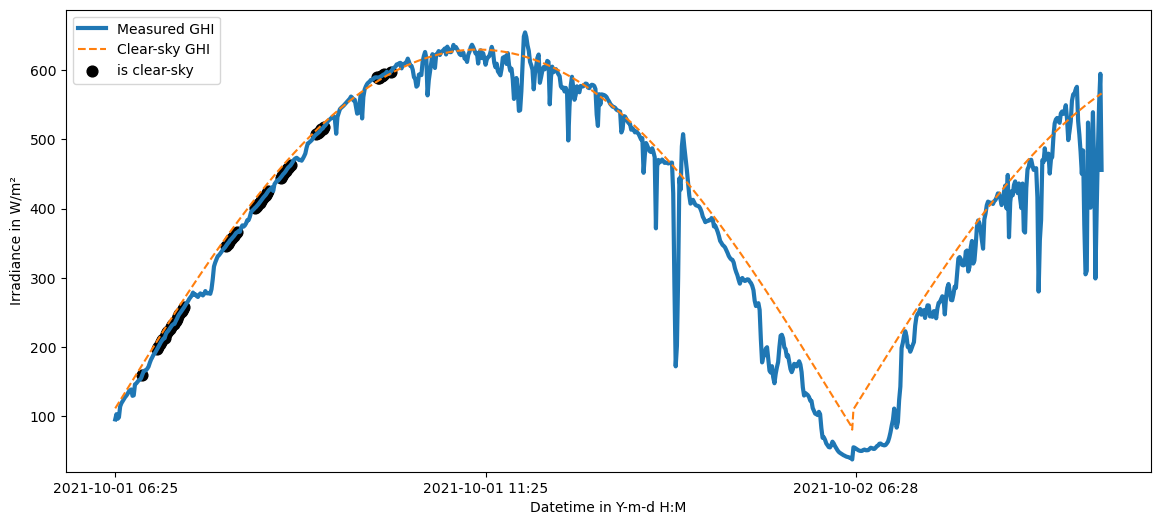

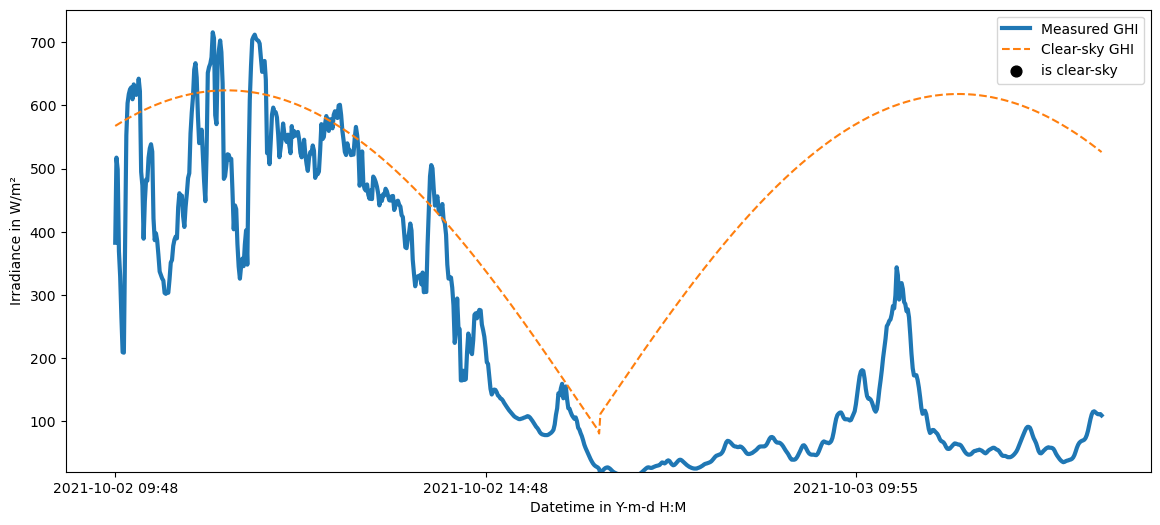

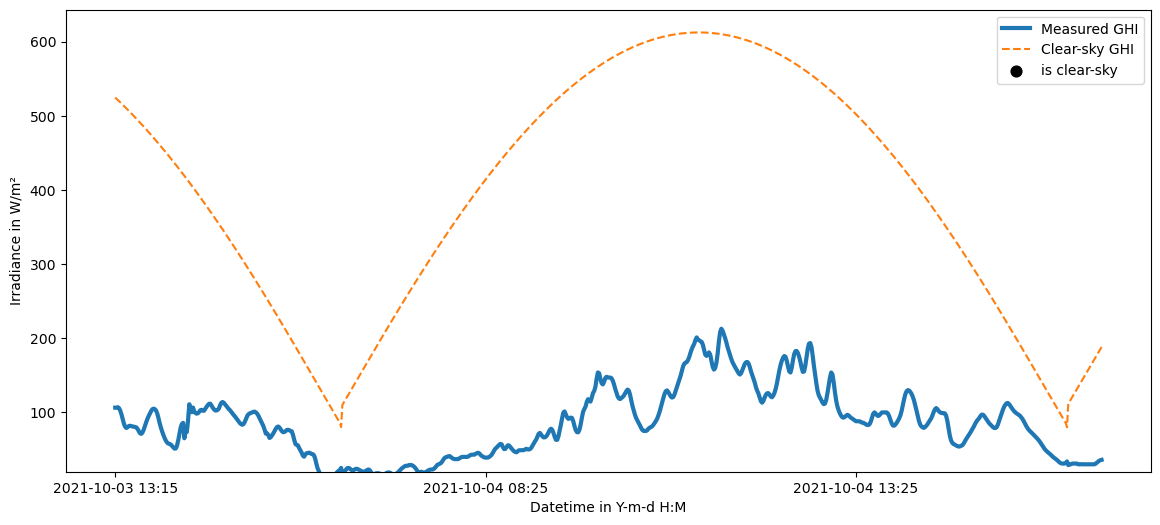

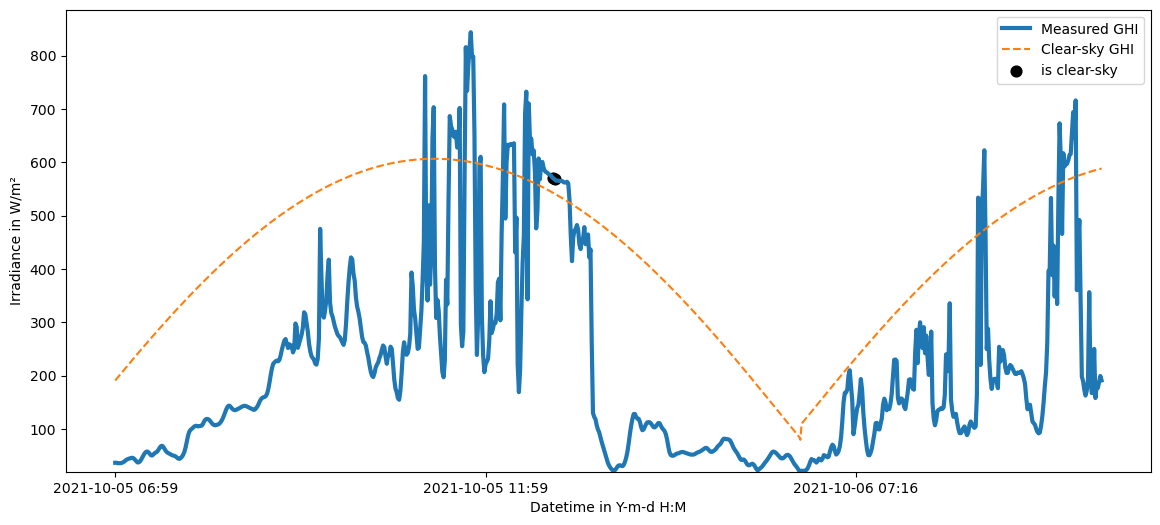

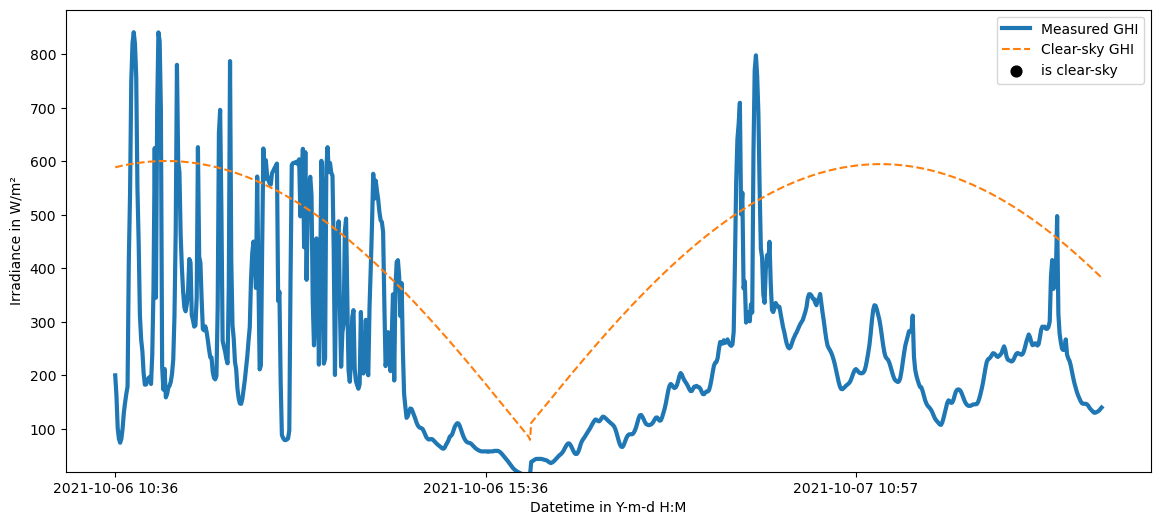

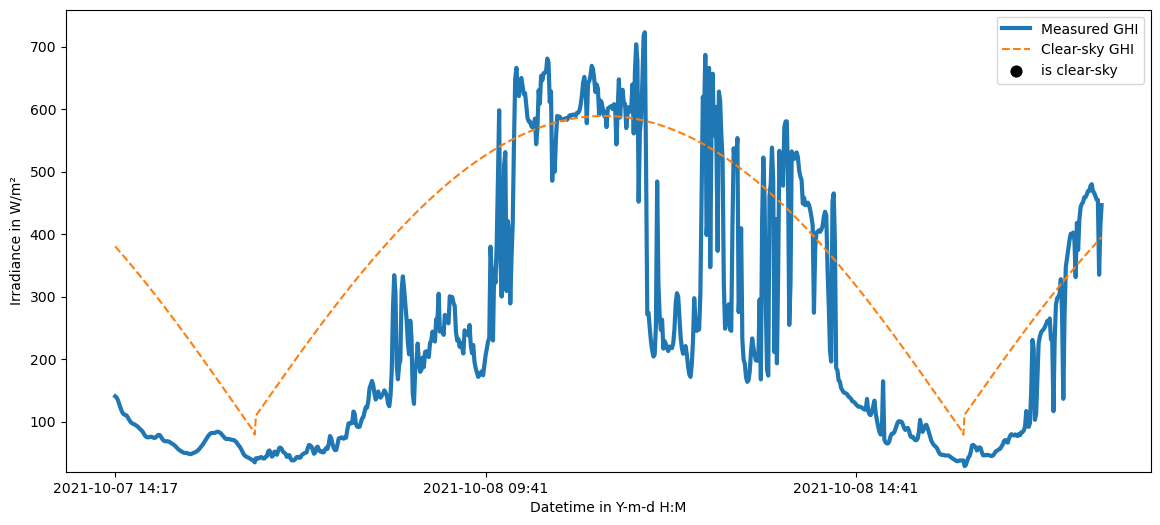

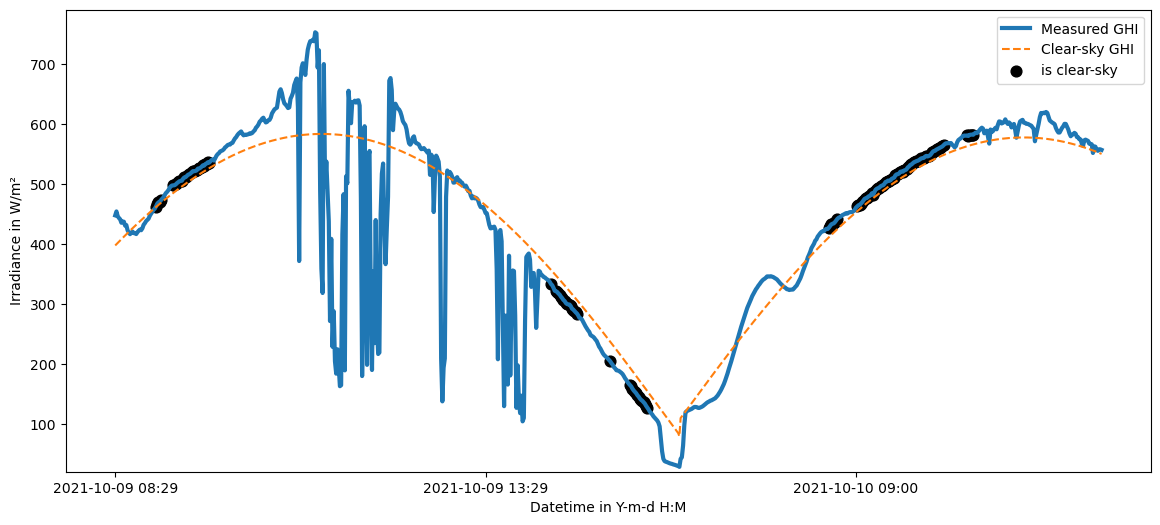

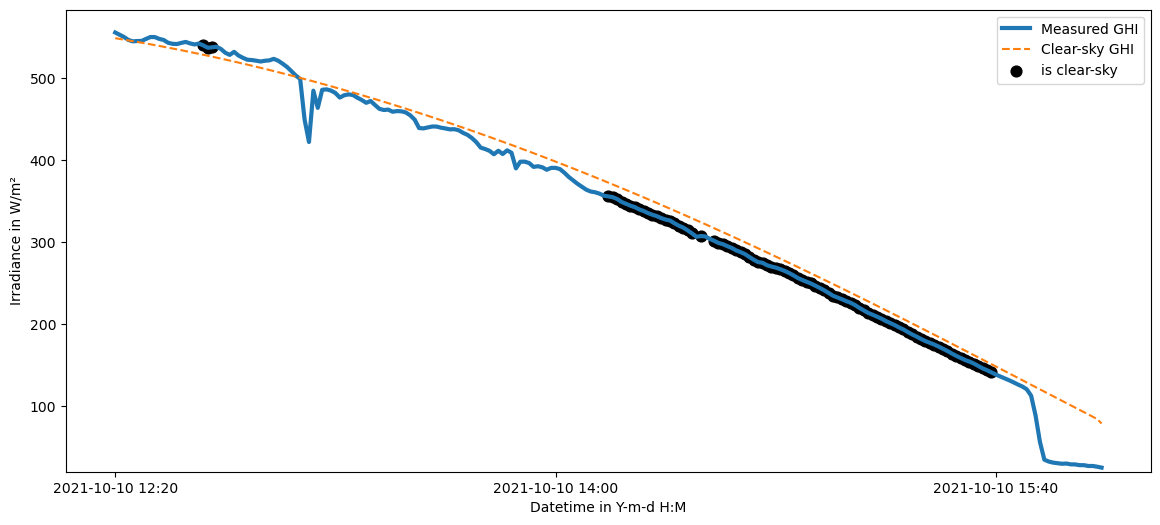

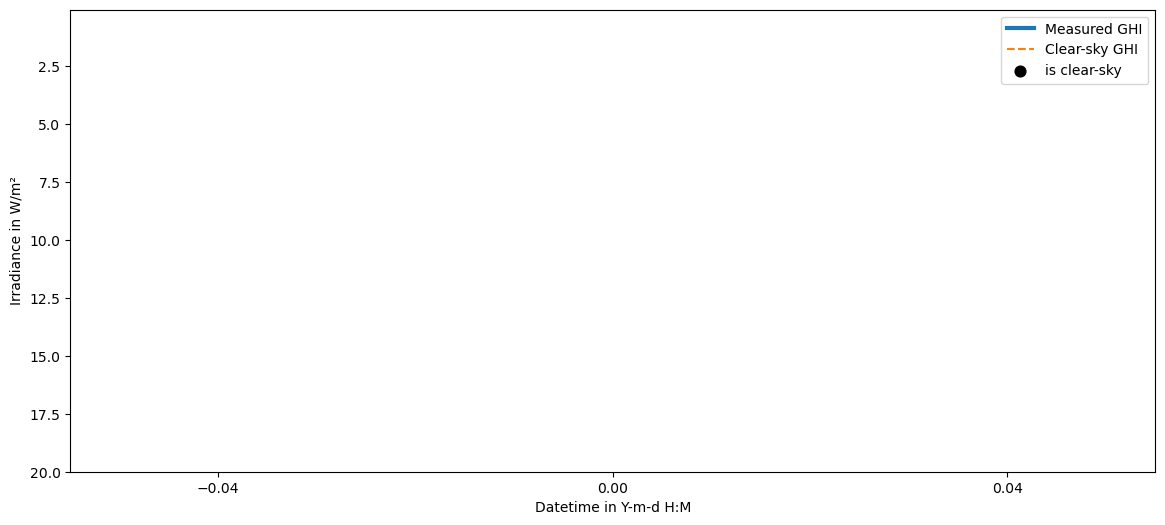

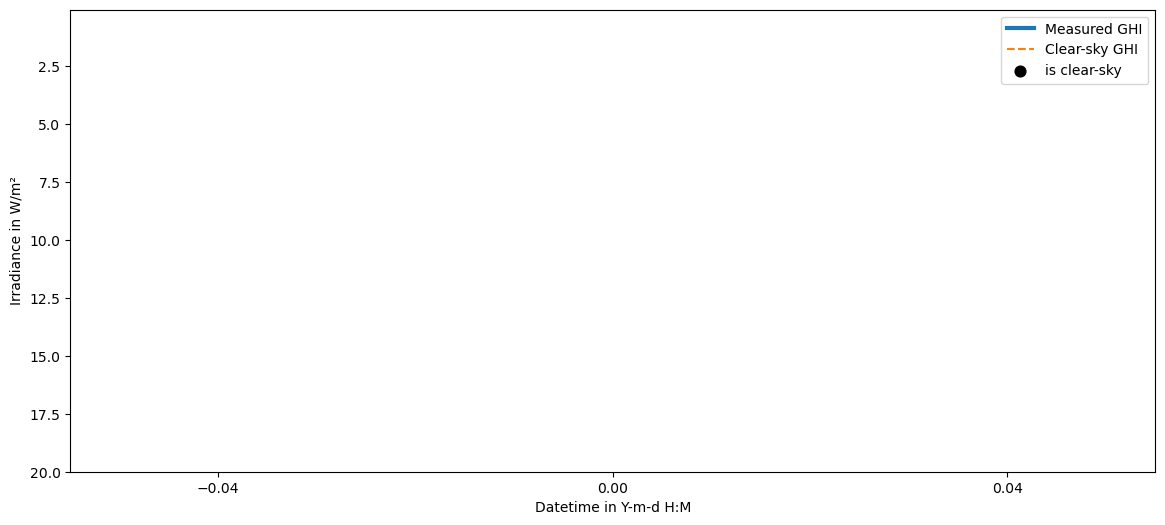

In [16]:
increment = 800 # how many minutes shall be plotted in one row
start = 0 # start minute
stop = 8000 # stop minute

while start < stop:
    end = start + increment
    evaluation_plot(label_df, col, start, end)
    start = end